# Random Forest Amplitude Baseline Walkthrough

Welcome! This notebook walks you step by step through the dummy baseline implemented. By the end you will understand every moving part of the script and know how to adapt it for your own experiments.


## Notebook Objectives

1. Get familiar with the Beacon sleep staging bundle and the helper utilities that load the data.
2. Recreate the amplitude-based feature engineering routine.
3. Visualise raw EEG alongside sleep stages to build intuition.
4. Train and evaluate the Random Forest classifier with a subject-aware split.
5. Generate a competition-ready submission file and persist the trained artefacts.


## How to Use This Notebook

Run the cells from top to bottom. Each section builds on the previous one and mirrors the flow of the command-line training script. If a cell raises an error about missing data or packages, follow the hint in the error message before rerunning the cell.


In [1]:
# pip install numpy pandas scikit-learn joblib matplotlib seaborn scipy

In [2]:
from pathlib import Path
import json
import os
import joblib
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler



In [3]:
sns.set_theme(style='whitegrid', context='talk')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


## Step 1 — Configure Paths and Hyperparameters

Choose where your data lives and where to store the outputs. Update the paths (or export `CS2025_DATA_ROOT`) if your layout differs from the default project structure.


In [4]:
# Base directory containing the Kaggle bundle and model outputs.
BUNDLE_DIR = Path(r"C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025") 
MODEL_DIR = BUNDLE_DIR / 'models'
MODEL_OUT = MODEL_DIR / 'rf_amplitude.joblib'
SUMMARY_OUT = MODEL_OUT.with_suffix('.json')
SUBMISSION_OUT = MODEL_DIR / 'rf_amplitude_submission.csv'

# Random Forest hyperparameters and shared constants.
TEST_SIZE = 0.25
N_ESTIMATORS = 400
MAX_DEPTH = None
RANDOM_STATE = 1234

VALID_LABELS = [0, 1, 2, 3, 4]
SAMPLING_RATE = 100
EPOCH_DURATION_SECONDS = 30
NUM_CHANNELS = 5
SAMPLES_PER_EPOCH = SAMPLING_RATE * EPOCH_DURATION_SECONDS

print(f'Bundle directory: {BUNDLE_DIR.absolute()}')

if not BUNDLE_DIR.exists():
    raise FileNotFoundError(
        f'Kaggle bundle not found at {BUNDLE_DIR}. Update DATA_ROOT or set CS2025_DATA_ROOT before continuing.'
    )


Bundle directory: C:\Users\mathias\Desktop\Codes\beacon-biosignals-sleep-staging-2025


## Step 2 — Data Access Helpers


In [5]:
from typing import Iterator, List, Tuple

SAMPLES_PER_CHANNEL = SAMPLING_RATE * EPOCH_DURATION_SECONDS


def _discover_record_ids(base_dir: Path, split: str) -> List[int]:
    """Return the ordered list of record IDs for a split."""
    manifest_path = base_dir / 'records_manifest.csv'
    if manifest_path.exists():
        manifest = pd.read_csv(manifest_path)
        subset = manifest[manifest['split'] == split]
        return subset['record_id'].astype(int).tolist()

    signal_dir = base_dir / f'signals_{split}'
    record_ids: List[int] = []
    for path in sorted(signal_dir.glob('signal_*.npy')):
        try:
            record_ids.append(int(path.stem.split('_')[-1]))
        except ValueError as exc:
            raise ValueError(f'Unexpected signal filename: {path.name}') from exc
    return record_ids


def _load_signal_array(path: Path) -> np.ndarray:
    """Load and validate a signal array shaped (NUM_CHANNELS, samples)."""
    array = np.load(path).astype(np.float32)
    if array.ndim != 2 or array.shape[0] != NUM_CHANNELS:
        raise ValueError(f'Signal array at {path} has shape {array.shape}, expected ({NUM_CHANNELS}, N_samples).')
    if array.shape[1] % SAMPLES_PER_CHANNEL != 0:
        raise ValueError(
            f'Signal array at {path} has {array.shape[1]} samples, not divisible by {SAMPLES_PER_CHANNEL}.'
        )
    return array


def _load_target_array(path: Path) -> np.ndarray:
    """Load the per-epoch labels (1D, int16)."""
    array = np.load(path).astype(np.int16)
    if array.ndim == 2 and array.shape[0] == NUM_CHANNELS:
        array = array[0]
    if array.ndim != 1:
        raise ValueError(f'Target array at {path} must be 1D, found shape {array.shape}.')
    return array


def iter_signals_and_targets(base_dir: Path, split: str) -> Iterator[Tuple[int, np.ndarray, np.ndarray]]:
    """Yield (record_id, signal_array, target_array) tuples for the chosen split."""
    record_ids = _discover_record_ids(base_dir, split)
    if not record_ids:
        raise FileNotFoundError(f'No records found for split={split} under {base_dir}.')

    signal_dir = base_dir / f'signals_{split}'
    target_dir = base_dir / f'targets_{split}'

    for record_id in record_ids:
        signal_path = signal_dir / f'signal_{record_id}.npy'
        target_path = target_dir / f'target_{record_id}.npy'
        if not signal_path.exists() or not target_path.exists():
            raise FileNotFoundError(f'Missing signal/target pair for record {record_id} in split {split}.')
        signal_array = _load_signal_array(signal_path)
        target_array = _load_target_array(target_path)
        yield record_id, signal_array, target_array

def iter_signals_only(base_dir: Path, split: str) -> Iterator[Tuple[int, np.ndarray]]:
    """Yield (record_id, signal_array) tuples without requiring targets."""
    record_ids = _discover_record_ids(base_dir, split)
    if not record_ids:
        raise FileNotFoundError(f'No records found for split={split} under {base_dir}.')

    signal_dir = base_dir / f'signals_{split}'

    for record_id in record_ids:
        signal_path = signal_dir / f'signal_{record_id}.npy'
        if not signal_path.exists():
            raise FileNotFoundError(f'Missing signal for record {record_id} in split {split}.')
        signal_array = _load_signal_array(signal_path)
        yield record_id, signal_array


## Step 3 — Inspect a Single Record

Before engineering features, take a quick tour of the raw arrays to confirm their shapes and label distribution.


In [6]:
def describe_first_record(bundle_dir: Path, split: str = 'train', preview_epochs: int = 2):
    """Print basic statistics for the first record in the requested split."""
    recordings = list(iter_signals_and_targets(bundle_dir, split))
    record_id, signal_array, target_array = recordings[3]
    print(f'Record ID: {record_id}')
    print(f'Signal shape: {signal_array.shape} (channels, samples)')
    print(f'Target shape: {target_array.shape} (epochs)')
    unique, counts = np.unique(target_array, return_counts=True)
    stage_counts = {int(stage): int(count) for stage, count in zip(unique, counts)}
    print('Stage distribution:', stage_counts)
    preview = signal_array[:, : preview_epochs * SAMPLES_PER_EPOCH]
    print(f'Previewed {preview.shape[1] // SAMPLES_PER_EPOCH} epochs worth of samples per channel.')
    return record_id, signal_array, target_array

example_record_id, example_signal, example_targets = describe_first_record(BUNDLE_DIR, 'train')


Record ID: 3
Signal shape: (5, 2970000) (channels, samples)
Target shape: (990,) (epochs)
Stage distribution: {0: 93, 1: 63, 2: 395, 3: 212, 4: 227}
Previewed 2 epochs worth of samples per channel.


### Sleep Stage Labels and Colours

The mapping below helps keep plots readable. Feel free to customise the colour palette or add channel names that match your sensor configuration.


In [7]:
STAGE_LABELS = {0: 'Wake', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM', -1: 'Unknown'}
STAGE_COLORS = {
    0: '#d4b483',  # Wake
    1: '#f7a399',  # N1
    2: '#7fcdbb',  # N2
    3: '#41b6c4',  # N3
    4: '#c51b8a',  # REM
    -1: '#9e9e9e',
}
CHANNEL_NAMES = {idx: f'Channel {idx}' for idx in range(NUM_CHANNELS)}


## Step 3a — Plot Example Epochs by Sleep Stage

Visualise one representative 30-second epoch per sleep stage for a chosen channel. This is a great way to see how the signal amplitude and morphology change across stages.


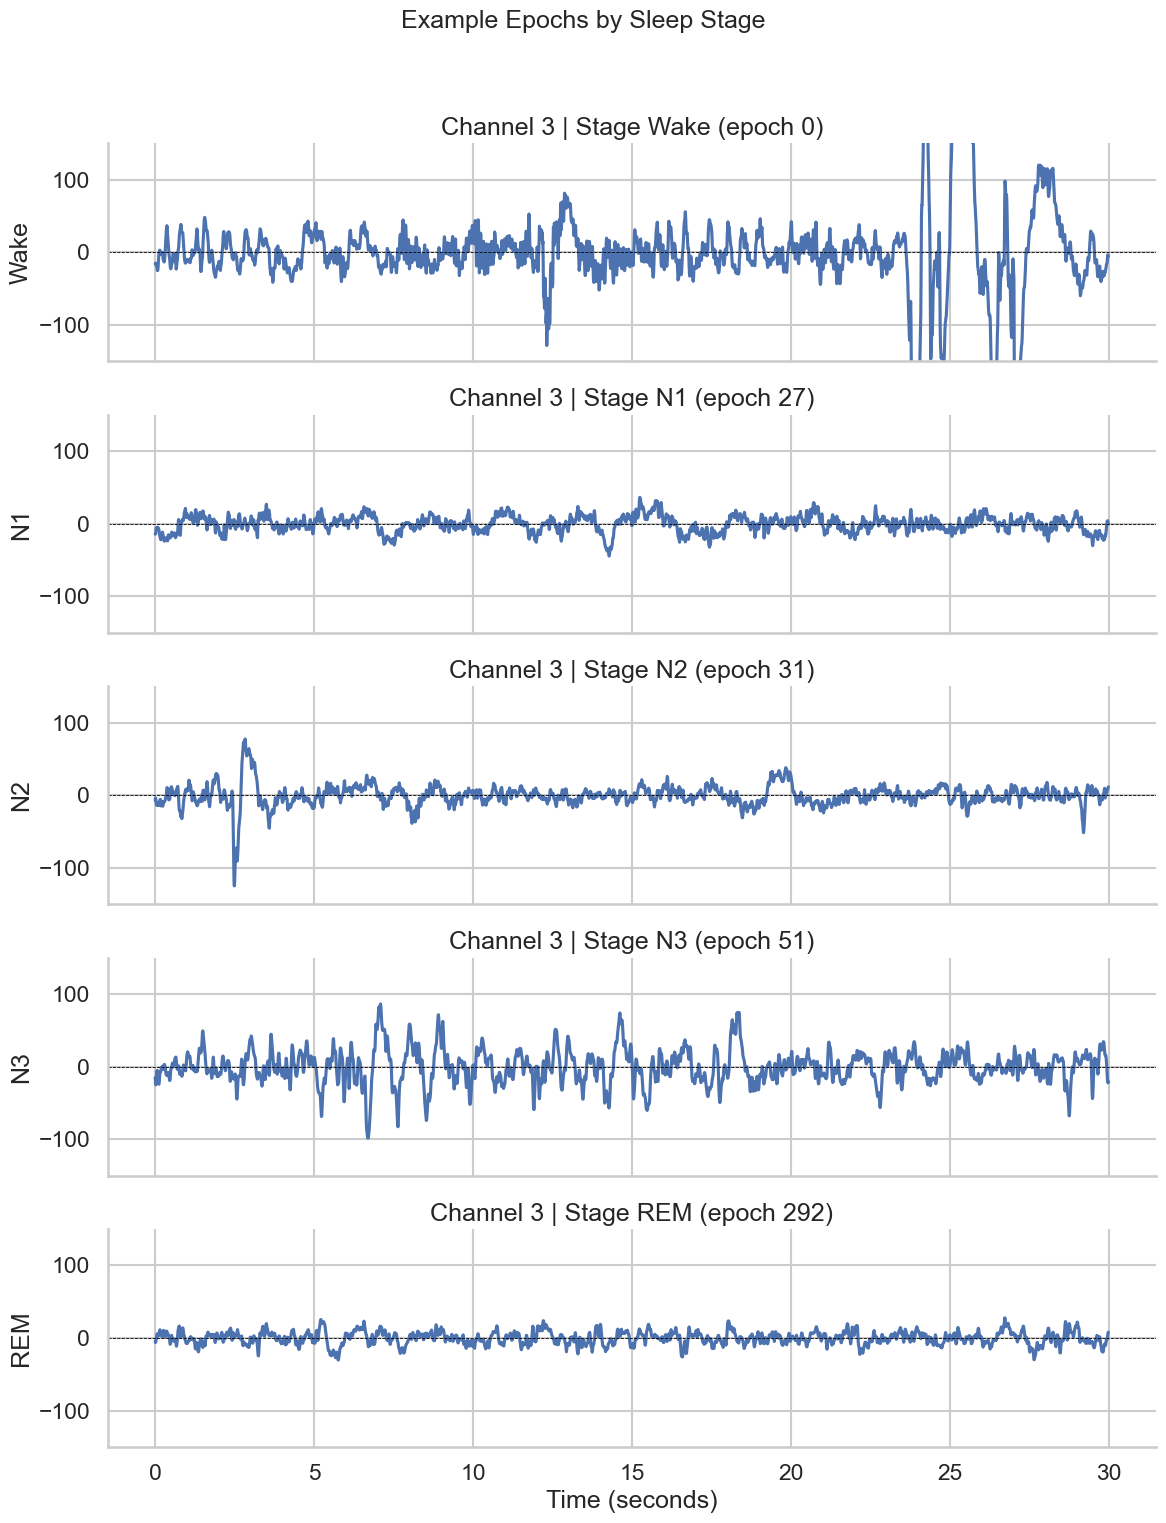

In [8]:
def plot_stage_examples(signal_array: np.ndarray, target_array: np.ndarray, channel: int = 0, stages=None):
    """Plot one example epoch per requested stage for the selected channel."""
    if stages is None:
        stages = VALID_LABELS
    available = []
    for stage in stages:
        matches = np.where(target_array == stage)[0]
        if matches.size:
            available.append((stage, int(matches[0])))
    if not available:
        raise ValueError('None of the requested stages are present in this record.')

    time_axis = np.arange(SAMPLES_PER_EPOCH) / SAMPLING_RATE
    fig, axes = plt.subplots(len(available), 1, figsize=(12, 3 * len(available)), sharex=True)
    if len(available) == 1:
        axes = [axes]

    for ax, (stage, epoch_idx) in zip(axes, available):
        start = epoch_idx * SAMPLES_PER_EPOCH
        epoch_data = signal_array[channel, start : start + SAMPLES_PER_EPOCH]
        ax.plot(time_axis, epoch_data)
        ax.axhline(0, color='black', linewidth=0.6, linestyle='--')
        ax.set_ylim(-150,150)
        ax.set_ylabel(STAGE_LABELS.get(stage, f'Stage {stage}'))
        ax.set_title(f'{CHANNEL_NAMES.get(channel, f"Channel {channel}")} | Stage {STAGE_LABELS.get(stage, stage)} (epoch {epoch_idx})')
    axes[-1].set_xlabel('Time (seconds)')
    fig.suptitle('Example Epochs by Sleep Stage', fontsize=18, y=1.02)
    plt.tight_layout()

plot_stage_examples(example_signal, example_targets, channel=3)


## Step 3b — Compare Channels Within a Single Epoch

Pick one epoch (for example the first REM segment) and plot all channels stacked together. This highlights inter-channel differences such as eye movements or muscle tone.


Visualising epoch 292 (Stage REM)


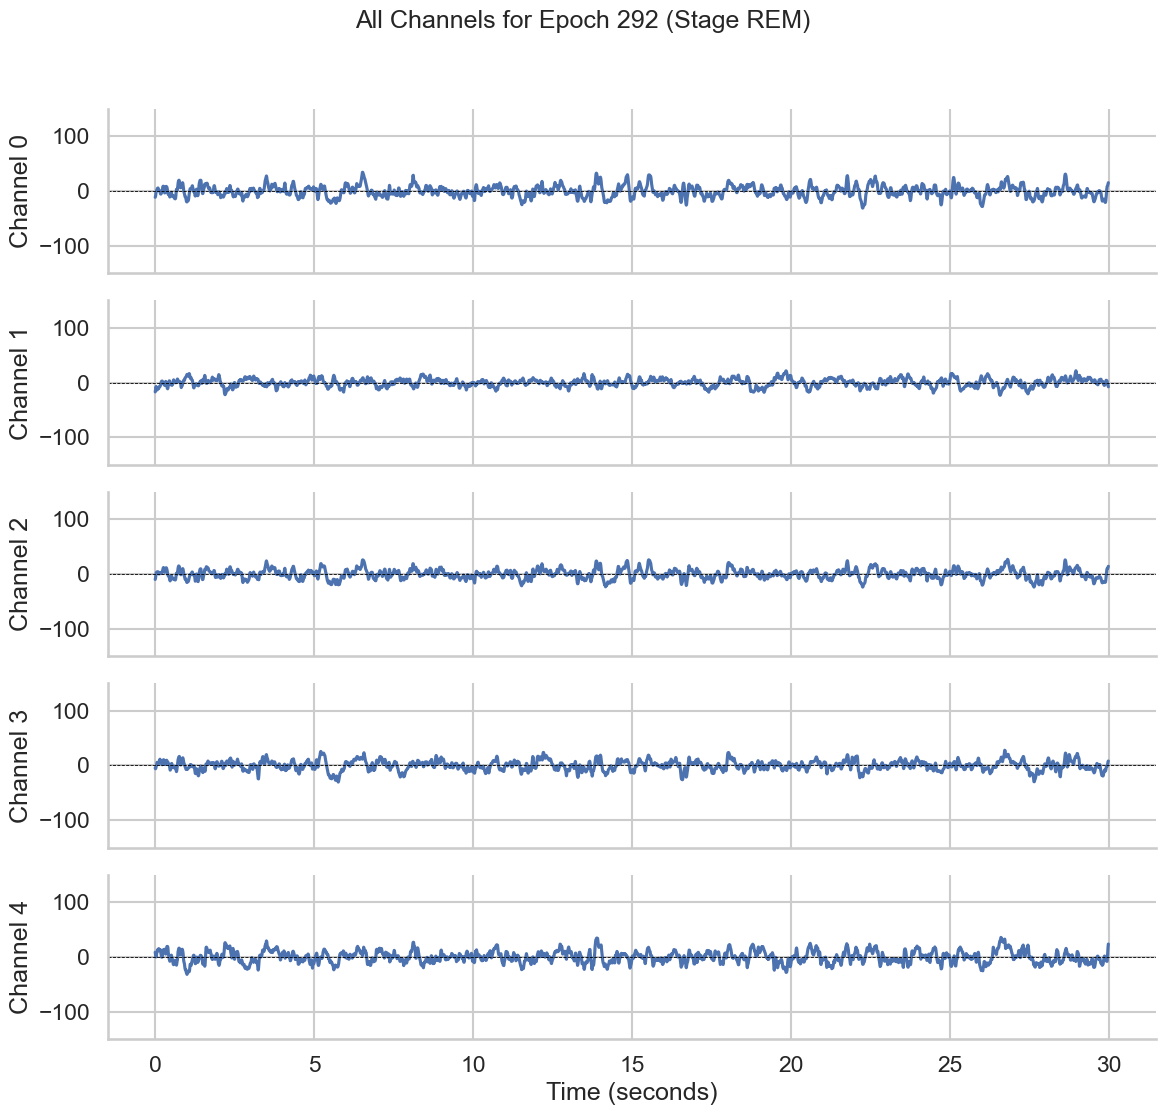

In [9]:
def plot_epoch_across_channels(signal_array: np.ndarray, target_array: np.ndarray, epoch_idx: int):
    """Plot every channel for a single epoch index."""
    if epoch_idx < 0 or epoch_idx >= target_array.size:
        raise IndexError(f'Epoch index {epoch_idx} is out of range for this record.')
    stage = int(target_array[epoch_idx])
    start = epoch_idx * SAMPLES_PER_EPOCH
    time_axis = np.arange(SAMPLES_PER_EPOCH) / SAMPLING_RATE

    fig, axes = plt.subplots(NUM_CHANNELS, 1, figsize=(12, 2.2 * NUM_CHANNELS), sharex=True)
    for ch, ax in enumerate(axes):
        epoch_data = signal_array[ch, start : start + SAMPLES_PER_EPOCH]
        ax.plot(time_axis, epoch_data, color='#4c72b0')
        ax.axhline(0, color='black', linewidth=0.6, linestyle='--')
        ax.set_ylabel(CHANNEL_NAMES.get(ch, f'Ch {ch}'))
        ax.set_ylim(-150,150)

    axes[-1].set_xlabel('Time (seconds)')
    fig.suptitle(
        f'All Channels for Epoch {epoch_idx} (Stage {STAGE_LABELS.get(stage, stage)})',
        fontsize=18,
        y=1.02,
    )
    plt.tight_layout()

# Choose an epoch to visualise — default to the first REM epoch, fall back to epoch 0.
rem_indices = np.where(example_targets == 4)[0]
example_epoch_idx = int(rem_indices[0]) if rem_indices.size else 0
print(f'Visualising epoch {example_epoch_idx} (Stage {STAGE_LABELS.get(int(example_targets[example_epoch_idx]), "?")})')
plot_epoch_across_channels(example_signal, example_targets, example_epoch_idx)


## Step 3c — Spectrogram and Hypnogram Overview

The figure below shows a time-frequency spectrogram for one channel alongside the up-sampled hypnogram. Spectral power concentrates in different bands depending on the sleep stage, which helps explain why even simple statistics can carry signal.

You can find more details on the frequency content of sleep stages here:
https://pmc.ncbi.nlm.nih.gov/articles/PMC5343535/


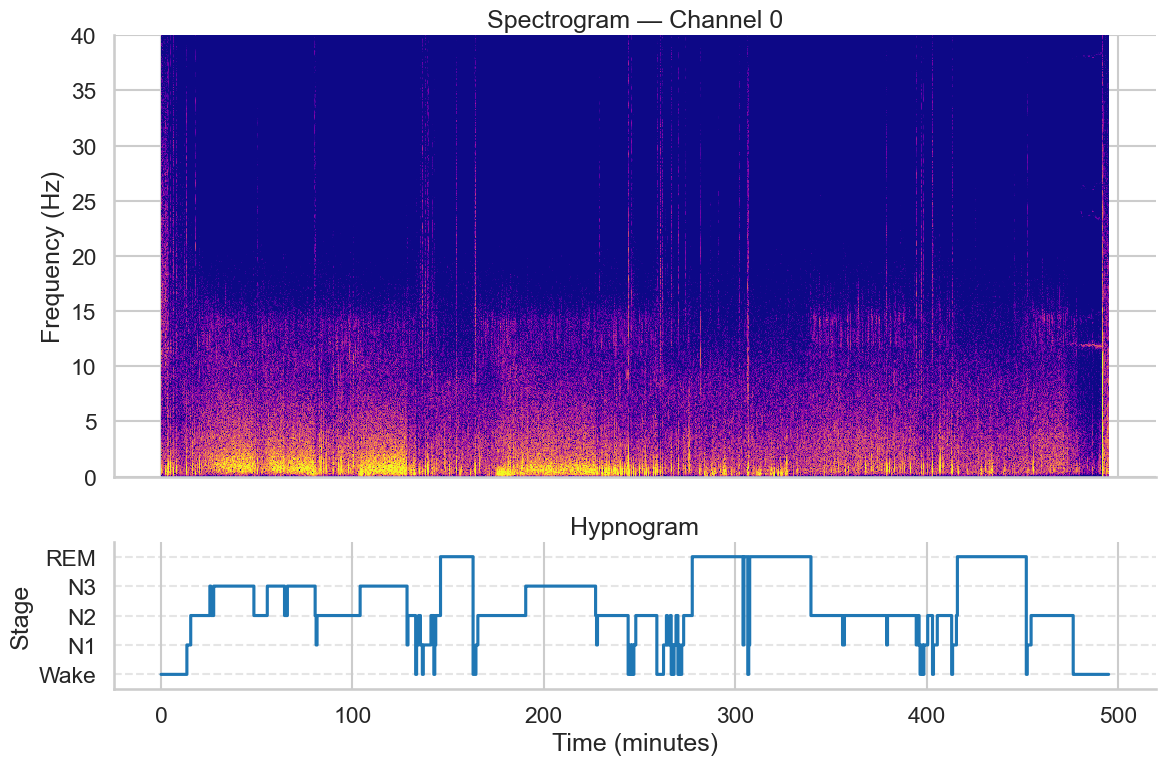

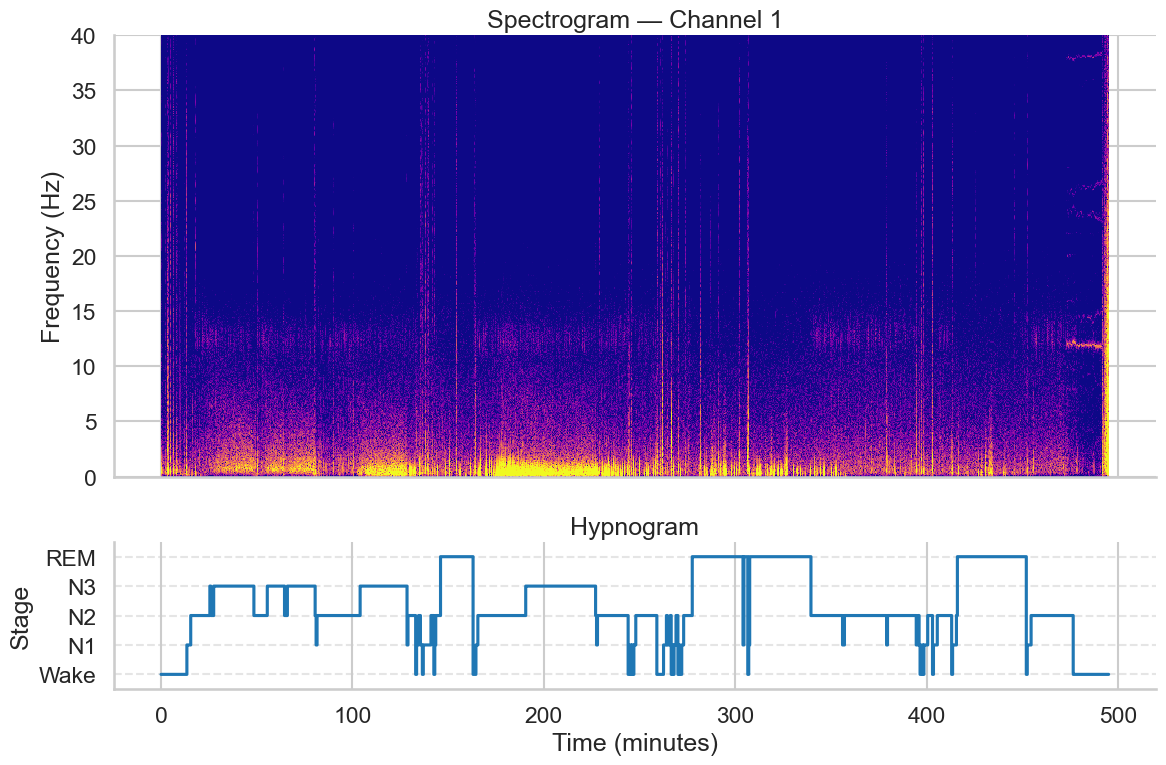

In [10]:
def _upsample_hypnogram(hypno: np.ndarray, samples_per_epoch: int, total_samples: int) -> np.ndarray:
    """Repeat hypnogram epochs so they align with raw sample spacing."""
    repeated = np.repeat(hypno, samples_per_epoch)
    if repeated.size < total_samples:
        pad_value = repeated[-1] if repeated.size else -1
        pad = np.full(total_samples - repeated.size, pad_value, dtype=repeated.dtype)
        repeated = np.concatenate([repeated, pad])
    return repeated[:total_samples]


def _compute_bin_edges(values: np.ndarray) -> np.ndarray:
    """Approximate bin edges from sample centres for pcolormesh."""
    if values.size < 2:
        step = 1.0
    else:
        step = np.diff(values).mean()
    edges = np.concatenate([
        [values[0] - step / 2],
        values[:-1] + step / 2,
        [values[-1] + step / 2],
    ])
    return edges


def plot_spectrogram_and_hypnogram(signal_array: np.ndarray, target_array: np.ndarray, channel: int = 0, max_freq: float = 40.0):
    """Plot a spectrogram with the corresponding hypnogram underneath."""
    data = signal_array[channel]
    freqs_spec, times_spec, spec = spectrogram(
        data,
        fs=SAMPLING_RATE,
        nperseg=SAMPLING_RATE * 10,
        noverlap=SAMPLING_RATE * 5,
        detrend=False,
        scaling="density",
        mode="psd"
    )
    power_db = 10 * np.log10(spec + 1e-12)
    power_db = np.clip(power_db,-5,30)
    hypno_samples = _upsample_hypnogram(target_array, SAMPLES_PER_EPOCH, data.size)
    hypno_time = np.arange(hypno_samples.size) / SAMPLING_RATE / 60

    time_edges = _compute_bin_edges(times_spec / 60)
    freq_edges = _compute_bin_edges(freqs_spec)

    fig, (ax_spec, ax_hypno) = plt.subplots(
        2,
        1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={'height_ratios': [3, 1]},
    )

    mesh = ax_spec.pcolormesh(time_edges, freq_edges, power_db, cmap='plasma')
    ax_spec.set_ylabel('Frequency (Hz)')
    ax_spec.set_title(f'Spectrogram — {CHANNEL_NAMES.get(channel, f"Channel {channel}")}')
    ax_spec.set_ylim(0, max_freq)

    ax_hypno.step(hypno_time, hypno_samples, where='post', color='#1f77b4')
    ax_hypno.set_ylabel('Stage')
    ax_hypno.set_xlabel('Time (minutes)')
    ax_hypno.set_yticks(sorted(STAGE_LABELS.keys()))
    ax_hypno.set_yticklabels([STAGE_LABELS[key] for key in sorted(STAGE_LABELS.keys())])
    ax_hypno.set_title('Hypnogram')
    ax_hypno.set_ylim(-0.5, 4.5)
    ax_hypno.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()

plot_spectrogram_and_hypnogram(example_signal, example_targets, channel=0)
plot_spectrogram_and_hypnogram(example_signal, example_targets, channel=1)


## Step 4 — Feature Engineering Helpers

Each 30-second epoch is summarised by four amplitude-based statistics per channel: standard deviation, minimum, maximum, and peak-to-peak range. These helpers match the functions in the CLI script.


In [ ]:
from typing import Dict, List, Tuple


def extract_epoch_stats(signal: np.ndarray) -> pd.DataFrame:
    """Convert a multi-channel signal into one row per epoch of amplitude statistics."""
    num_epochs = signal.shape[1] // SAMPLES_PER_EPOCH
    rows: List[Dict[str, float]] = []
    for epoch_idx in range(num_epochs):
        start = epoch_idx * SAMPLES_PER_EPOCH
        end = start + SAMPLES_PER_EPOCH
        row: Dict[str, float] = {'epoch_index': epoch_idx}
        for ch in range(NUM_CHANNELS):
            channel_signal = signal[ch, start:end]
            row[f'ch{ch}_std'] = float(np.std(channel_signal))
            row[f'ch{ch}_min'] = float(channel_signal.min())
            row[f'ch{ch}_max'] = float(channel_signal.max())
            row[f'ch{ch}_ptp'] = float(np.ptp(channel_signal))  # peak-to-peak range
        rows.append(row)
    return pd.DataFrame(rows)


def build_dataset(
    bundle_dir: Path,
    split: str,
    drop_invalid: bool = True,
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, pd.DataFrame]:
    """Create the feature table, labels, and per-record group IDs for a split."""
    feature_frames: List[pd.DataFrame] = []
    labels: List[np.ndarray] = []
    groups: List[np.ndarray] = []

    for record_id, signal_array, target_array in iter_signals_and_targets(bundle_dir, split):
        frame = extract_epoch_stats(signal_array)
        frame['record_id'] = record_id
        feature_frames.append(frame)

        stages = target_array if target_array.ndim == 1 else target_array[0]
        labels.append(stages[: frame.shape[0]])
        groups.append(np.full(frame.shape[0], record_id, dtype=np.int64))

    features = pd.concat(feature_frames, ignore_index=True)
    y = np.concatenate(labels).astype(np.int64)
    groups_arr = np.concatenate(groups).astype(np.int64)
    mask = np.isin(y, VALID_LABELS)

    if drop_invalid:
        features = features.loc[mask].reset_index(drop=True)
        y = y[mask]
        groups_arr = groups_arr[mask]
    meta = features[['record_id', 'epoch_index']].reset_index(drop=True)

    feature_cols = [col for col in features.columns if col not in {'record_id', 'epoch_index'}]
    return features[feature_cols], y, groups_arr, meta


def evaluate(model: RandomForestClassifier, X: np.ndarray, y: np.ndarray) -> Tuple[float, float, str]:
    """Compute accuracy, macro F1, and a detailed classification report."""
    preds = model.predict(X)
    mask = np.isin(y, VALID_LABELS)
    if mask.sum() == 0:
        raise ValueError('No scored epochs available for evaluation.')
    y_masked = y[mask]
    preds_masked = preds[mask]
    acc = accuracy_score(y_masked, preds_masked)
    macro_f1 = f1_score(y_masked, preds_masked, average='macro')
    report = classification_report(y_masked, preds_masked, digits=3)
    return acc, macro_f1, report


## Step 5 — Assemble the Training Table

Load every training record, compute the amplitude features, and keep a group ID per record so that we can later split by subject.


In [12]:
X_df, y, groups, train_meta = build_dataset(BUNDLE_DIR, 'train', drop_invalid=True)
print(f'Feature matrix shape: {X_df.shape}')
print(f'Number of labels (epochs): {y.shape[0]}')
print(f'Unique records (groups): {np.unique(groups).size}')
unique_labels, counts = np.unique(y, return_counts=True)
label_counts = dict(zip(unique_labels.astype(int), counts.astype(int)))
print('Label distribution:', label_counts)


Feature matrix shape: (7433, 20)
Number of labels (epochs): 7433
Unique records (groups): 8
Label distribution: {np.int64(0): np.int64(1200), np.int64(1): np.int64(509), np.int64(2): np.int64(3269), np.int64(3): np.int64(1034), np.int64(4): np.int64(1421)}


## Step 6 — Preview the Engineered Features

Each row corresponds to one 30-second epoch. The columns follow the pattern `ch<channel>_<statistic>`.


In [21]:
X_df.head()


,ch0_std,ch0_min,ch0_max,ch0_ptp,ch1_std,ch1_min,ch1_max,ch1_ptp,ch2_std,ch2_min,ch2_max,ch2_ptp,ch3_std,ch3_min,ch3_max,ch3_ptp,ch4_std,ch4_min,ch4_max,ch4_ptp
0,14.748470,-48.057274,50.724537,98.781815,9.868649,-34.139107,28.031101,62.170208,14.940137,-49.766178,52.279408,102.045586,19.156635,-67.986938,84.604477,152.591415,15.657406,-49.656414,53.023392,102.679810
1,13.479313,-47.664841,44.938030,92.602875,10.761889,-33.379131,38.473232,71.852364,13.365528,-44.376301,47.617195,91.993500,16.705683,-57.334995,63.577480,120.912476,15.209505,-61.318268,54.494770,115.813034
2,12.754451,-40.995800,38.321629,79.317429,12.616886,-35.074650,36.007763,71.082413,12.786792,-37.265766,38.607204,75.872971,15.894444,-45.378029,68.583969,113.961998,15.382261,-48.180893,62.903275,111.084167
3,12.342356,-36.973747,48.952374,85.926117,10.898625,-33.208801,33.620014,66.828812,11.644698,-37.523716,46.018715,83.542435,15.332358,-43.931164,65.512947,109.444107,13.394090,-49.262760,45.204140,94.466904
4,12.303305,-38.078606,55.881653,93.960258,11.492809,-34.299324,31.219952,65.519272,11.919007,-37.271744,58.120087,95.391830,14.578304,-67.635323,59.162266,126.797592,13.015830,-49.806198,39.853085,89.659286


## Step 7 — Standardise the Features

Scaling keeps the Random Forest from being dominated by features with large numeric ranges.


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_df)
print(f'Scaled matrix shape: {X.shape}')


## Step 8 — Create a Group-Aware Train/Validation Split

Subjects should not appear on both sides of the split, so we use `GroupShuffleSplit` with record IDs as groups.


In [ ]:
splitter = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, val_idx = next(splitter.split(X, y, groups))
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]
print(f'Train epochs: {X_train.shape[0]} | Validation epochs: {X_val.shape[0]}')


Train epochs: 5802 | Validation epochs: 1631


## Step 9 — Train the Random Forest Classifier

This is the exact configuration used by the baseline script.


In [29]:
model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    n_jobs=-1,
    class_weight='balanced',
    random_state=RANDOM_STATE,
)
model.fit(X_train, y_train)


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Step 10 — Evaluate on the Validation Split

Accuracy is easy to read, while macro F1 tells us how well the model balances rare stages.


In [30]:
val_acc, val_macro_f1, val_report = evaluate(model, X_val, y_val)
print(f'Validation accuracy: {val_acc:.4f}')
print(f'Validation macro F1: {val_macro_f1:.4f}')
print(val_report)


Validation accuracy: 0.6094
Validation macro F1: 0.4825
              precision    recall  f1-score   support

           0      0.850     0.206     0.332       465
           1      0.133     0.026     0.044        76
           2      0.619     0.916     0.739       596
           3      0.938     0.777     0.850       273
           4      0.349     0.624     0.448       221

    accuracy                          0.609      1631
   macro avg      0.578     0.510     0.483      1631
weighted avg      0.679     0.609     0.570      1631



## Step 11 — Build the Submission DataFrame

Competition submissions require an `identifier` column combining record ID and epoch index. We mirror the CLI logic to ensure IDs match the provided template.


In [31]:
test_feature_frames = []
test_meta_frames = []

for record_id, signal_array in iter_signals_only(BUNDLE_DIR, 'test'):
    frame = extract_epoch_stats(signal_array)
    frame['record_id'] = record_id
    test_feature_frames.append(frame[X_df.columns])
    test_meta_frames.append(frame[['record_id', 'epoch_index']])

test_X_df = pd.concat(test_feature_frames, ignore_index=True)
test_meta = pd.concat(test_meta_frames, ignore_index=True)

test_X = scaler.transform(test_X_df)
predictions = model.predict(test_X)

identifiers = (
    test_meta['record_id'].to_numpy(dtype=np.int64) * 10000
    + test_meta['epoch_index'].to_numpy(dtype=np.int64)
)
submission = pd.DataFrame({'identifier': identifiers, 'target': predictions})

sample_path = BUNDLE_DIR / 'sample.csv'
if sample_path.exists():
    sample = pd.read_csv(sample_path)
    submission = sample.drop(columns=['target']).merge(submission, on='identifier', how='left')
    missing = submission['target'].isna().sum()
    if missing:
        raise ValueError(f'Missing predictions for {missing} identifiers compared to sample template.')

submission.head()

,identifier,target
0,80000,2
1,80001,2
2,80002,3
3,80003,2
4,80004,2


## Step 12 — Save the Model, Summary, and Submission

Persist everything so that you can reuse the trained model or upload the CSV without rerunning the notebook.


In [32]:
submission.to_csv("submission.csv", index=False)